# RSI momentum trading strategy example

- This is a backtest example notebook
    - Check high trading fee options for ETH-MATIC-USDC

# Set up

Set up Trading Strategy data client.

In [1]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()


# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)
# etup_charting_and_output(width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/datalore/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [2]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["BTCUSDT", "ETHUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.h8,
    stop_loss_time_bucket=TimeBucket.h1,
    start_at=datetime.datetime(2019, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 3, 15),
    include_lending=False
)

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]

100%|██████████| 2/2 [00:00<00:00, 23.05it/s, pair=ETHUSDT, total_size (MBytes)=3.83]


# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [3]:
from tradingstrategy.chain import ChainId

pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

Loaded 11,402 candles.
Pair <Pair #1 BTC - USDT at exchange binance> first close price 3713.83 at 2019-01-01 00:00:00
Pair <Pair #2 ETH - USDT at exchange binance> first close price 133.56 at 2019-01-01 00:00:00


# Indicators

- Prepare indicators needed for the grid

In [4]:
import pandas_ta
import pandas as pd

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_price_series


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_eth_btc(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price, upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price, upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_btc / resampled_eth  # Divide two series
    return series


def calculate_eth_btc(strategy_universe: TradingStrategyUniverse):
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])    
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    series = eth_price["close"] / btc_price["close"]  # Divide two series
    return series

def calculate_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int):
    weth_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WETH", "USDC"))
    wbtc_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WBTC", "USDC"))
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(wbtc_usdc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(weth_usdc.internal_id)
    eth_btc = eth_price["close"] / btc_price["close"]
    return pandas_ta.rsi(eth_btc, length=length)

def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    # Calculate RSI for all pairs
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    # Custom: ETC/BTC close price
    indicators.add("eth_btc", calculate_shifted_eth_btc, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    # Custom: ETC/BTC RSI
    # indicators.add("eth_btc_rsi", calculate_eth_btc_rsi, parameters={"length": parameters.eth_btc_rsi_bars}, source=IndicatorSource.strategy_universe)

# Trading algorithm

In [5]:
import pandas as pd

from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.strategy.weighting import weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # Resolve our pair metadata for our two pair strategy
    parameters = input.parameters 
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    shift = parameters.shift
    clock_shift = pd.Timedelta(hours=1) * shift

    # Execute the daily trade cycle when the clock hour 0..24 is correct for our hourly shift
    assert parameters.upsample.to_timedelta() >= parameters.cycle_duration.to_timedelta(), "Upsample period must be longer than cycle period"    
    assert shift <= 0  # Shift -1 = do action 1 hour later

    # Override the trading fee to simulate worse fees and price impact
    if parameters.trading_fee_override is not None:
        input.pricing_model.set_trading_fee_override(parameters.trading_fee_override)    

    # Do the clock shift trick
    if parameters.cycle_duration.to_timedelta() != parameters.upsample.to_timedelta():
        if (input.cycle - 1 + shift) % int(parameters.upsample.to_hours()) != 0:
            return []

    alpha_model = AlphaModel(input.timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])
    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {btc_pair: 0, eth_pair: 0}
    eth_btc_rsi_yesterday = None

    for pair in [btc_pair, eth_pair]:        
        current_price[pair] = indicators.get_price(pair)

        current_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-1, pair=pair, clock_shift=clock_shift)
        previous_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-2, pair=pair, clock_shift=clock_shift)

        if shift and input.cycle > 100:
            indicators.get_indicator_value("rsi", index=-1 + shift, pair=pair, clock_shift=clock_shift)

    eth_btc_yesterday = indicators.get_indicator_value("eth_btc", clock_shift=clock_shift)
    eth_btc_rsi_yesterday = indicators.get_indicator_value("eth_btc_rsi", clock_shift=clock_shift)
    if eth_btc_rsi_yesterday is not None:
        eth_momentum = (eth_btc_rsi_yesterday / 100) + 0.5 
        btc_momentum = (1 - (eth_btc_rsi_yesterday / 100)) + 0.5
        momentum[eth_pair] = eth_momentum ** parameters.momentum_exponent
        momentum[btc_pair] = btc_momentum ** parameters.momentum_exponent

    #
    # Trading logic
    #

    for pair in [btc_pair, eth_pair]:

        # Each pair has its own bullish/bearish regime

        price = current_price[pair] 

        # 
        # Regime filter
        #
        # If no indicator data yet, or regime filter disabled,
        # be always bullish
        bullish = True  
        if parameters.regime_filter_ma_days:  # Regime filter is not disabled
            regime_filter_pair = btc_pair if parameters.regime_filter_only_btc else pair
            regime_filter_price = current_price[regime_filter_pair]
            sma = indicators.get_indicator_value("sma", index=-1, pair=regime_filter_pair, clock_shift=clock_shift)
            if sma:
                # We are bearish if close price is beloe SMA
                bullish = regime_filter_price > sma
        
        if bullish:
            rsi_entry = parameters.bullish_rsi_entry
            rsi_exit = parameters.bullish_rsi_exit
        else:
            rsi_entry = parameters.bearish_rsi_entry
            rsi_exit = parameters.bearish_rsi_exit            

        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            if rsi_entry:
                rsi_cross_above = current_rsi_values[pair] >= rsi_entry and previous_rsi_values[pair] < rsi_entry
            else:
                # bearish_rsi_entry = None -> don't trade in bear market
                rsi_cross_above = False

            rsi_cross_below = current_rsi_values[pair] < rsi_exit and previous_rsi_values[pair] > rsi_exit

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)
            else:
                # We have open position, check for the close condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Enable trailing stop loss if we have reached the activation level
    if parameters.trailing_stop_loss_activation_level is not None and parameters.trailing_stop_loss is not None:
       for p in state.portfolio.open_positions.values():
           if p.trailing_stop_loss_pct is None:
               if current_price[p.pair] >= p.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                   p.trailing_stop_loss_pct = parameters.trailing_stop_loss

    # Use alpha model and construct a portfolio of two assets
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.rebalance_threshold * portfolio.get_total_equity(),
    )

    #
    # Visualisations
    #

    if input.is_visualisation_enabled():

        visualisation = state.visualisation  # Helper class to visualise strategy output

        # BTC RSI daily
        if current_rsi_values[btc_pair]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI BTC",
                PlotKind.technical_indicator_detached,
                current_rsi_values[btc_pair],
                colour="orange",
            )


            # Low (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI low trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_low,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

            # High (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI high trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_high,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

        # ETH RSI daily
        if current_rsi_values[eth_pair]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI ETH",
                PlotKind.technical_indicator_overlay_on_detached,
                current_rsi_values[eth_pair],
                colour="blue",
                label=PlotLabel.hidden,
                detached_overlay_name=f"RSI BTC",
            )

        if eth_btc_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC",
                PlotKind.technical_indicator_detached,
                eth_btc_yesterday,
                colour="grey",
            )

        if eth_btc_rsi_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                eth_btc_rsi_yesterday,
                colour="grey",
            )

        state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    position_manager.log(
        f"BTC RSI: {current_rsi_values[btc_pair]}, BTC RSI yesterday: {previous_rsi_values[btc_pair]}",
    )

    return trades

# Strategy indicators

- Set up indicators used to decide trades
- Indicator data will be precalculated and cached between strategy runs 
- The actual calculation is run (if needed) later on `run_backtest_inline()` call

In [6]:
import pandas_ta

from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def calculate_shifted_btc_price(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """"BTC price (shifted)

    "For diagnostics.
    """
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    return resampled_btc


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_sma(pair_close_price_series: pd.Series, days: int | None, upsample: TimeBucket, shift: int):
    if days:
        # Calculate trading pair simple moving average for X days
        resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
        return pandas_ta.sma(resampled_close, length=days * (TimeBucket.d1.to_hours() / upsample.to_hours()))
    else:
        # Regime filter disabled in the parameters
        return pd.Series(dtype="float64")


def calculate_shifted_eth_btc(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    eth = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_eth / resampled_btc
    return series


def calculate_shifted_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int, upsample: TimeBucket, shift: int):
     """ETH/BTC RSI series."""
     etc_btc = calculate_shifted_eth_btc(strategy_universe, upsample, shift)
     return pandas_ta.rsi(etc_btc, length=length)


def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("sma", calculate_shifted_sma, {"days": parameters.regime_filter_ma_days, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("eth_btc", calculate_shifted_eth_btc, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    indicators.add("eth_btc_rsi", calculate_shifted_eth_btc_rsi, {"upsample": parameters.upsample, "shift": parameters.shift, "length": parameters.eth_btc_rsi_bars}, source=IndicatorSource.strategy_universe)
    indicators.add("resampled_btc", calculate_shifted_btc_price, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)

# Parameters

- Set up strategy parameters for this backtest run

In [7]:
class HighFeeStopLossStrategyParameters:
    cycle_duration = CycleDuration.cycle_8h
    rsi_bars = [8, 12, 21, 30]
    eth_btc_rsi_bars = 5
    
    bullish_rsi_entry = [50, 55, 60, 65, 70, 75, 80]
    bullish_rsi_exit = [50, 55, 60, 65, 70, 75, 80]

    bearish_rsi_entry = [50, 55, 60, 65, 67, 70, 75, 80, None]
    bearish_rsi_exit = [50, 54, 60, 65, 67, 70, 75, 80]

    regime_filter_ma_days = [50, 100, 150, 200, None] 
    regime_filter_only_btc = [1, 0]

    allocation = 0.98 
    rebalance_threshold = 0.275
    initial_cash = 10_000 
    #trailing_stop_loss = 0.975
    #trailing_stop_loss_activation_level = 1.06
    #stop_loss = 0.85
    trailing_stop_loss = None
    trailing_stop_loss_activation_level = None
    stop_loss = None
    shift = 0    
    upsample = TimeBucket.h8
    momentum_exponent = 2.5
    trading_fee_override = 0.0030
    

# Grid search

Run the grid search.

In [8]:
from tradeexecutor.backtest.grid_search import GridCombination, get_grid_search_result_path, perform_grid_search, prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = get_grid_search_result_path("v43")

# Popular grid search combinations and indicators for them
combinations = prepare_grid_combinations(
    HighFeeStopLossStrategyParameters, 
    storage_folder,
    create_indicators=create_indicators,
    strategy_universe=strategy_universe,
)

indicators = GridCombination.get_all_indicators(combinations)

print(f"We prepared {len(combinations)} grid search combinations with total {len(indicators)} indicators which need to be calculated, stored in {storage_folder.resolve()}")

grid_search_results = perform_grid_search(
    decide_trades,
    strategy_universe,
    combinations,
    trading_strategy_engine_version="0.5",
    multiprocess=True,
)

We prepared 141120 grid search combinations with total 21 indicators which need to be calculated, stored in /home/datalore/.cache/trading-strategy/grid-search/v43
Using indicator cache /home/datalore/.cache/indicators/centralised-exchange_8h_BTC-USDT-ETH-USDT_2019-01-01-2024-03-15
Using grid search cache /home/datalore/.cache/trading-strategy/grid-search/v43, for indicators bearish_rsi_entry, bearish_rsi_exit, bullish_rsi_entry, bullish_rsi_exit, regime_filter_ma_days, regime_filter_only_btc, rsi_bars
All results were cached, grid search skipped


Reading cached search results w/ 30 threads: 100%|██████████| 141120/141120 [02:08<00:00, 1100.79it/s]


# Grid search result comparison

In [9]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import visualise_table

# Print extension of our backtest
cached_results = [r for r in grid_search_results if r.cached]
print(f"Grid search results available: {len(grid_search_results)}, of which we got cached {len(cached_results)} in {storage_folder}")

#table = analyse_grid_search_result(grid_search_results)
#table = table.reset_index()
#visualise_table(table)

Grid search results available: 141120, of which we got cached 141120 in /home/datalore/.cache/trading-strategy/grid-search/v43


## Best CAGR and Sharpe - overall

In [10]:
from tradeexecutor.analysis.grid_search import find_best_grid_search_results, render_grid_search_result_table
from tradeexecutor.visual.grid_search import visualise_single_grid_search_result_benchmark

best_results = find_best_grid_search_results(grid_search_results)
render_grid_search_result_table(best_results.cagr)


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_days 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 50 
 55 
 50 
 100.000000 
 0 
 30 
 162 
 817 
 60.00% 
 99.13% 
 -42.00% 
 1.570000 
 2.370000 
 0.06% 
 -1.41% 
 
 
 nan 
 1 
 30 
 111 
 666 
 56.00% 
 100.95% 
 -35.00% 
 1.610000 
 2.420000 
 0.48% 
 -1.54% 
 
 
 60 
 55 
 100.000000 
 0 
 30 
 161 
 628 
 50.00% 
 106.72% 
 -40.00% 
 1.720000 
 2.630000 
 0.37% 
 -1.25% 
 
 
 200.000000 
 0 
 30 
 163 
 646 
 50.00% 
 103.75% 
 -41.00% 
 1.680000 
 2.560000 
 0.22% 
 -1.41% 
 
 
 1 
 30 
 164 
 643 
 50.00% 
 98.39% 
 -46.00% 
 1.620000 
 2.440000 
 0.07% 
 -1.49% 
 
 
 55 
 50 
 50 
 75 
 150.000000 
 1 
 30 
 58 
 772 
 73.00% 
 104.84% 
 -56.00% 
 1.520000 
 2.200000 
 2.24% 
 -0.06% 
 
 
 80 
 150.000000 
 1 
 30 
 47 
 802 
 77.00% 
 111.25% 
 -57.00% 
 1.530000 
 2.200000 
 0.65% 
 -0.70% 
 
 
 200.000000 
 1 
 30 
 45 
 823 
 79.00% 
 100.31% 
 -57.00% 
 1.430000 
 2.040000 
 0.55% 
 -0.70% 
 
 
 60 
 55 
 100.000000 
 0 
 30 
 109 
 475 
 45.00% 
 109.65% 
 -36.00% 
 1.780000 
 2.720000 
 0.98% 
 -1.14% 
 
 
 150.000000 
 0 
 30 
 108 
 485 
 46.00% 
 106.41% 
 -36.00% 
 1.750000 
 2.660000 
 0.80% 
 -1.27% 
 
 
 200.000000 
 0 
 30 
 105 
 486 
 46.00% 
 114.92% 
 -36.00% 
 1.820000 
 2.790000 
 0.88% 
 -1.14% 
 
 
 80 
 150.000000 
 1 
 30 
 48 
 883 
 78.00% 
 109.17% 
 -60.00% 
 1.510000 
 2.180000 
 0.56% 
 -0.59% 
 
 
 54 
 60 
 55 
 100.000000 
 0 
 30 
 124 
 495 
 43.00% 
 112.60% 
 -36.00% 
 1.830000 
 2.810000 
 0.88% 
 -1.54% 
 
 
 65 
 60 
 55 
 100.000000 
 0 
 30 
 93 
 503 
 58.00% 
 102.15% 
 -49.00% 
 1.610000 
 2.410000 
 1.90% 
 0.28% 
 
 
 60 
 50 
 60 
 55 
 150.000000 
 1 
 30 
 93 
 414 
 42.00% 
 102.62% 
 -36.00% 
 1.740000 
 2.650000 
 0.97% 
 -1.04% 
 
 
 65 
 65 
 50 
 55 
 50.000000 
 1 
 21 
 117 
 550 
 65.00% 
 108.24% 
 -57.00% 
 1.670000 
 2.440000 
 2.89% 
 0.97% 
 
 
 55 
 50 
 50.000000 
 1 
 30 
 83 
 631 
 63.00% 
 113.86% 
 -48.00% 
 1.670000 
 2.490000 
 1.56% 
 -0.12% 
 
 
 67 
 60 
 80 
 200.000000 
 0 
 30 
 26 
 1004 
 84.00% 
 111.89% 
 -68.00% 
 1.490000 
 2.140000 
 3.47% 
 1.32% 
 
 
 70 
 55 
 50 
 50.000000 
 1 
 30 
 78 
 641 
 63.00% 
 125.52% 
 -47.00% 
 1.750000 
 2.610000 
 2.00% 
 -0.11% 
 
 
 60 
 50 
 50.000000 
 1 
 30 
 62 
 554 
 57.00% 
 117.34% 
 -54.00% 
 1.730000 
 2.580000 
 3.04% 
 0.98%

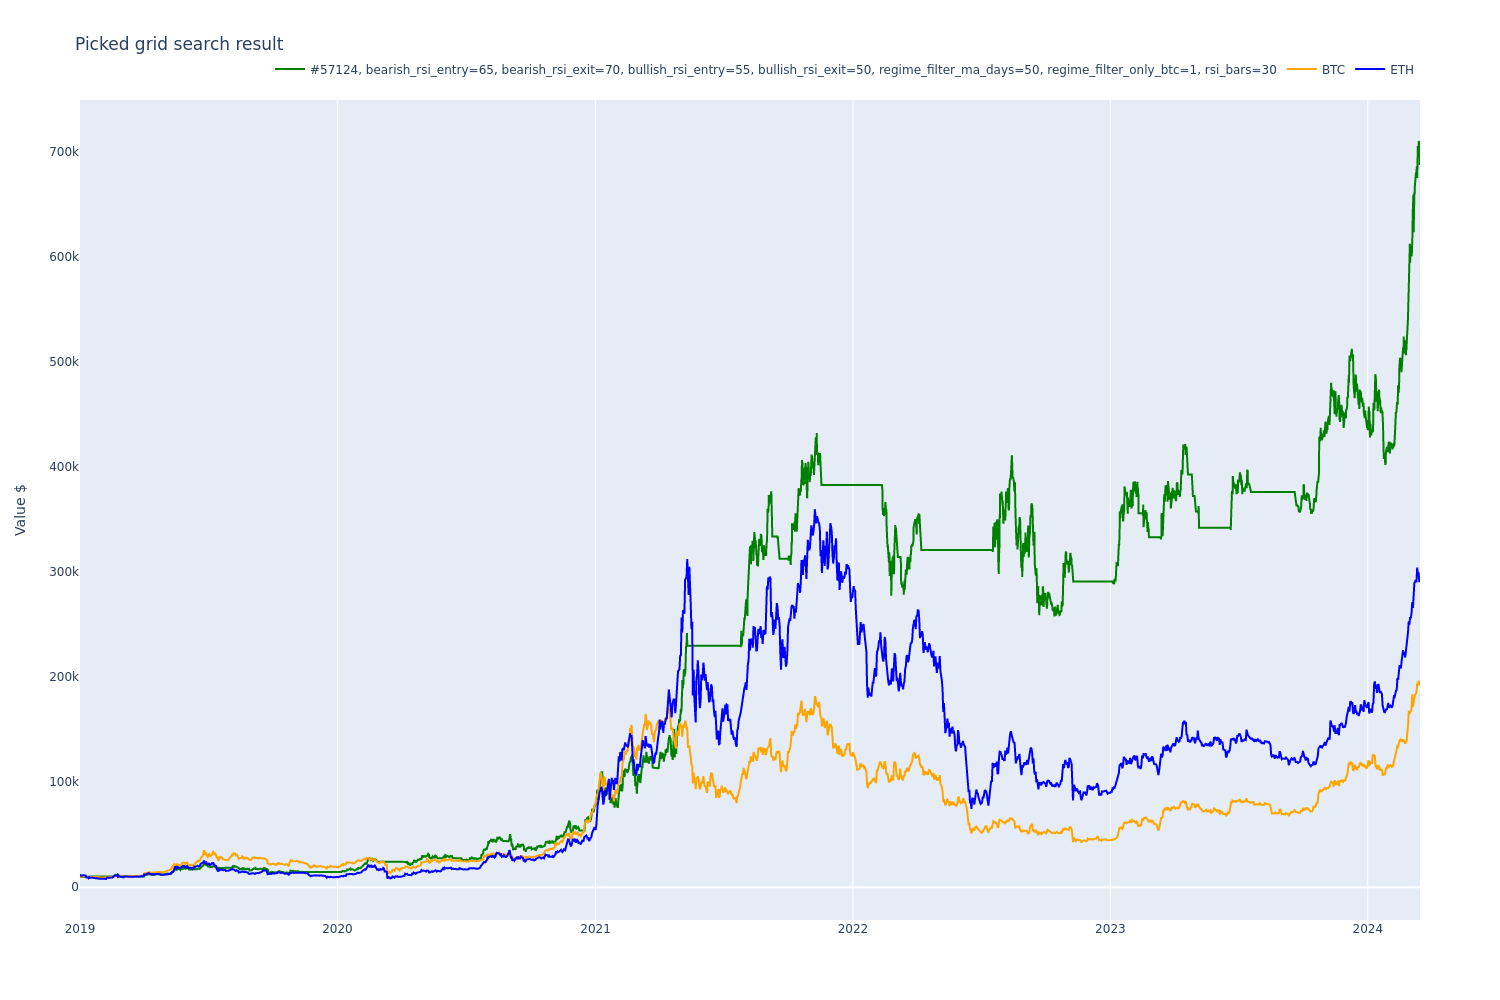

In [11]:
fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe)
fig.show()

In [12]:
render_grid_search_result_table(best_results.sharpe)

Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_days 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 55 
 50 
 60 
 55 
 100 
 0 
 30 
 109 
 475 
 45.00% 
 109.65% 
 -36.00% 
 1.780000 
 2.720000 
 0.98% 
 -1.14% 
 
 
 150 
 1 
 30 
 108 
 485 
 46.00% 
 107.07% 
 -36.00% 
 1.750000 
 2.670000 
 0.74% 
 -1.47% 
 
 
 200 
 0 
 30 
 105 
 486 
 46.00% 
 114.92% 
 -36.00% 
 1.820000 
 2.790000 
 0.88% 
 -1.14% 
 
 
 1 
 30 
 106 
 480 
 46.00% 
 111.07% 
 -36.00% 
 1.790000 
 2.730000 
 0.75% 
 -1.27% 
 
 
 54 
 60 
 55 
 100 
 0 
 30 
 124 
 495 
 43.00% 
 112.60% 
 -36.00% 
 1.830000 
 2.810000 
 0.88% 
 -1.54% 
 
 
 1 
 30 
 127 
 500 
 43.00% 
 106.39% 
 -36.00% 
 1.770000 
 2.700000 
 0.73% 
 -1.66% 
 
 
 150 
 1 
 30 
 127 
 510 
 43.00% 
 104.14% 
 -36.00% 
 1.740000 
 2.660000 
 0.62% 
 -1.63% 
 
 
 200 
 0 
 30 
 125 
 507 
 43.00% 
 105.76% 
 -36.00% 
 1.760000 
 2.690000 
 0.66% 
 -1.63% 
 
 
 60 
 54 
 60 
 55 
 200 
 1 
 30 
 97 
 415 
 41.00% 
 99.81% 
 -36.00% 
 1.730000 
 2.640000 
 1.02% 
 -1.14% 
 
 
 65 
 50 
 60 
 55 
 200 
 0 
 30 
 81 
 363 
 39.00% 
 103.96% 
 -36.00% 
 1.810000 
 2.750000 
 1.33% 
 -0.79% 
 
 
 70 
 50 
 60 
 55 
 150 
 0 
 30 
 81 
 347 
 36.00% 
 99.97% 
 -36.00% 
 1.800000 
 2.730000 
 1.09% 
 -1.14% 
 
 
 200 
 0 
 30 
 76 
 347 
 36.00% 
 112.38% 
 -36.00% 
 1.930000 
 2.950000 
 1.61% 
 -0.33% 
 
 
 60 
 60 
 55 
 200 
 0 
 30 
 77 
 349 
 35.00% 
 112.54% 
 -36.00% 
 1.940000 
 2.970000 
 1.66% 
 -0.55% 
 
 
 65 
 60 
 55 
 200 
 0 
 30 
 78 
 351 
 35.00% 
 109.12% 
 -36.00% 
 1.910000 
 2.930000 
 1.53% 
 -0.67% 
 
 
 70 
 60 
 55 
 200 
 0 
 30 
 79 
 341 
 35.00% 
 113.04% 
 -36.00% 
 1.950000 
 3.000000 
 1.58% 
 -0.84% 
 
 
 75 
 50 
 60 
 55 
 200 
 0 
 30 
 75 
 332 
 35.00% 
 114.23% 
 -36.00% 
 1.970000 
 3.020000 
 1.74% 
 -0.55% 
 
 
 54 
 60 
 55 
 200 
 0 
 30 
 77 
 336 
 34.00% 
 106.15% 
 -36.00% 
 1.890000 
 2.890000 
 1.45% 
 -1.04% 
 
 
 65 
 60 
 55 
 100 
 1 
 30 
 79 
 345 
 38.00% 
 101.21% 
 -36.00% 
 1.840000 
 2.800000 
 1.42% 
 -0.55% 
 
 
 80 
 50 
 60 
 55 
 200 
 0 
 30 
 75 
 332 
 35.00% 
 113.35% 
 -36.00% 
 1.960000 
 3.010000 
 1.73% 
 -0.55% 
 
 
 54 
 60 
 55 
 200 
 0 
 30 
 77 
 336 
 34.00% 
 105.31% 
 -36.00% 
 1.880000 
 2.870000 
 1.44% 
 -1.04%

In [0]:
fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

## Best with no regime filter

In [13]:
filtered_results = [r for r in grid_search_results if r.combination.get_parameter("regime_filter_ma_length") is None]

best_results = find_best_grid_search_results(filtered_results)
print("By CAGR")
render_grid_search_result_table(best_results.cagr)

ValueError: ValueError: No parameter: regime_filter_ma_length

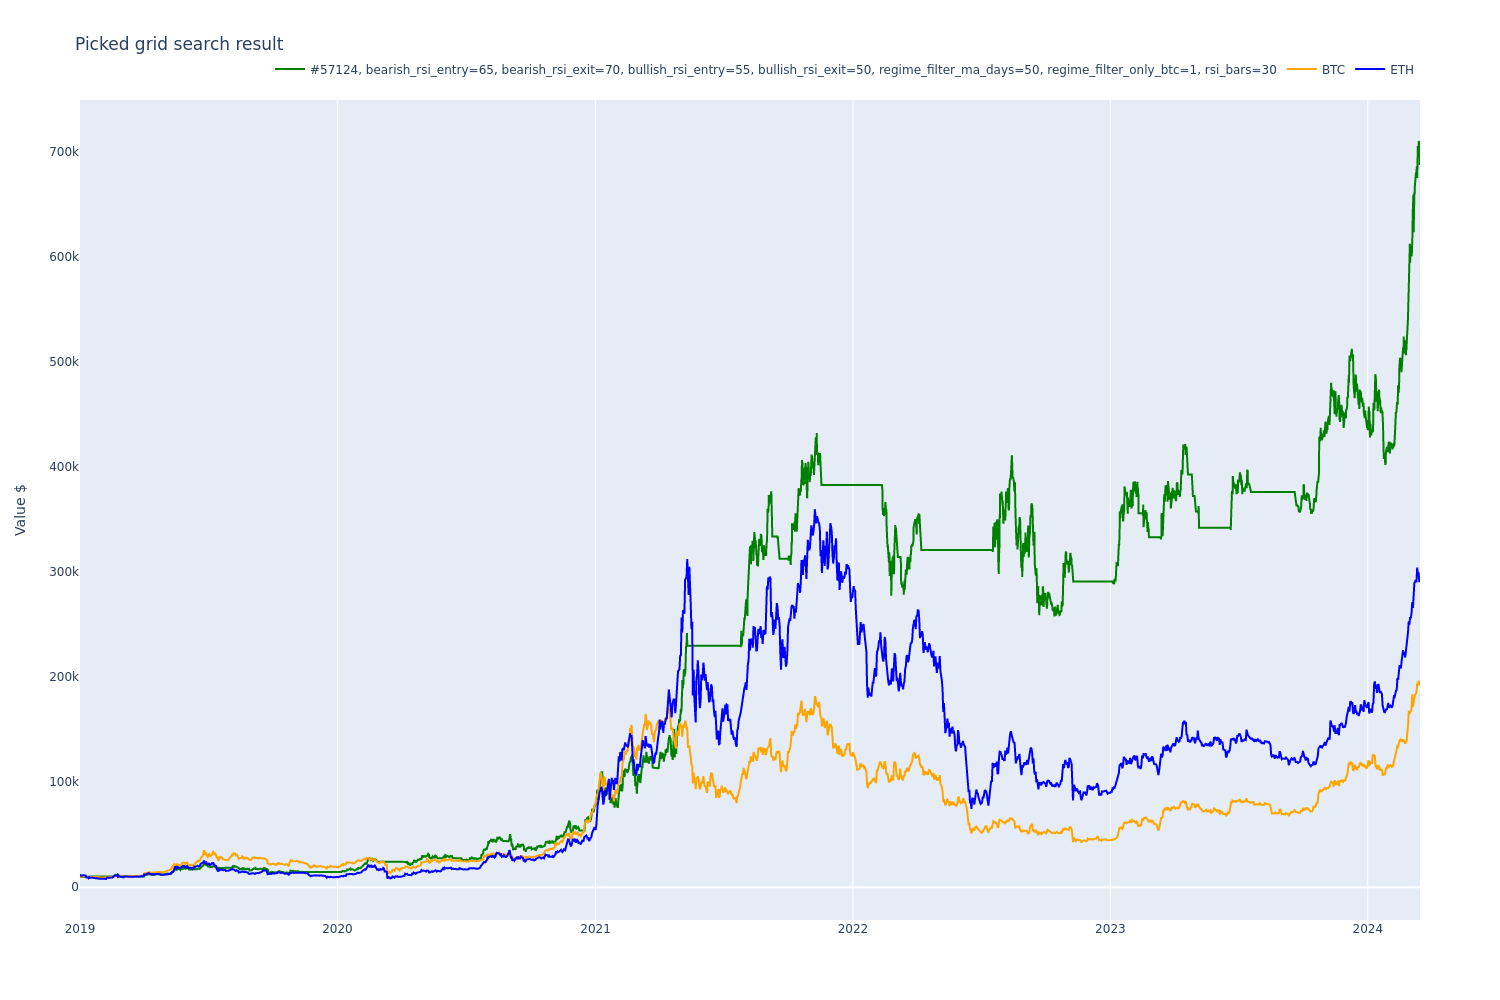

In [14]:
fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

In [15]:
print("By Sharpe")
render_grid_search_result_table(best_results.sharpe)


By Sharpe


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_days 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 55 
 50 
 60 
 55 
 100 
 0 
 30 
 109 
 475 
 45.00% 
 109.65% 
 -36.00% 
 1.780000 
 2.720000 
 0.98% 
 -1.14% 
 
 
 150 
 1 
 30 
 108 
 485 
 46.00% 
 107.07% 
 -36.00% 
 1.750000 
 2.670000 
 0.74% 
 -1.47% 
 
 
 200 
 0 
 30 
 105 
 486 
 46.00% 
 114.92% 
 -36.00% 
 1.820000 
 2.790000 
 0.88% 
 -1.14% 
 
 
 1 
 30 
 106 
 480 
 46.00% 
 111.07% 
 -36.00% 
 1.790000 
 2.730000 
 0.75% 
 -1.27% 
 
 
 54 
 60 
 55 
 100 
 0 
 30 
 124 
 495 
 43.00% 
 112.60% 
 -36.00% 
 1.830000 
 2.810000 
 0.88% 
 -1.54% 
 
 
 1 
 30 
 127 
 500 
 43.00% 
 106.39% 
 -36.00% 
 1.770000 
 2.700000 
 0.73% 
 -1.66% 
 
 
 150 
 1 
 30 
 127 
 510 
 43.00% 
 104.14% 
 -36.00% 
 1.740000 
 2.660000 
 0.62% 
 -1.63% 
 
 
 200 
 0 
 30 
 125 
 507 
 43.00% 
 105.76% 
 -36.00% 
 1.760000 
 2.690000 
 0.66% 
 -1.63% 
 
 
 60 
 54 
 60 
 55 
 200 
 1 
 30 
 97 
 415 
 41.00% 
 99.81% 
 -36.00% 
 1.730000 
 2.640000 
 1.02% 
 -1.14% 
 
 
 65 
 50 
 60 
 55 
 200 
 0 
 30 
 81 
 363 
 39.00% 
 103.96% 
 -36.00% 
 1.810000 
 2.750000 
 1.33% 
 -0.79% 
 
 
 70 
 50 
 60 
 55 
 150 
 0 
 30 
 81 
 347 
 36.00% 
 99.97% 
 -36.00% 
 1.800000 
 2.730000 
 1.09% 
 -1.14% 
 
 
 200 
 0 
 30 
 76 
 347 
 36.00% 
 112.38% 
 -36.00% 
 1.930000 
 2.950000 
 1.61% 
 -0.33% 
 
 
 60 
 60 
 55 
 200 
 0 
 30 
 77 
 349 
 35.00% 
 112.54% 
 -36.00% 
 1.940000 
 2.970000 
 1.66% 
 -0.55% 
 
 
 65 
 60 
 55 
 200 
 0 
 30 
 78 
 351 
 35.00% 
 109.12% 
 -36.00% 
 1.910000 
 2.930000 
 1.53% 
 -0.67% 
 
 
 70 
 60 
 55 
 200 
 0 
 30 
 79 
 341 
 35.00% 
 113.04% 
 -36.00% 
 1.950000 
 3.000000 
 1.58% 
 -0.84% 
 
 
 75 
 50 
 60 
 55 
 200 
 0 
 30 
 75 
 332 
 35.00% 
 114.23% 
 -36.00% 
 1.970000 
 3.020000 
 1.74% 
 -0.55% 
 
 
 54 
 60 
 55 
 200 
 0 
 30 
 77 
 336 
 34.00% 
 106.15% 
 -36.00% 
 1.890000 
 2.890000 
 1.45% 
 -1.04% 
 
 
 65 
 60 
 55 
 100 
 1 
 30 
 79 
 345 
 38.00% 
 101.21% 
 -36.00% 
 1.840000 
 2.800000 
 1.42% 
 -0.55% 
 
 
 80 
 50 
 60 
 55 
 200 
 0 
 30 
 75 
 332 
 35.00% 
 113.35% 
 -36.00% 
 1.960000 
 3.010000 
 1.73% 
 -0.55% 
 
 
 54 
 60 
 55 
 200 
 0 
 30 
 77 
 336 
 34.00% 
 105.31% 
 -36.00% 
 1.880000 
 2.870000 
 1.44% 
 -1.04%

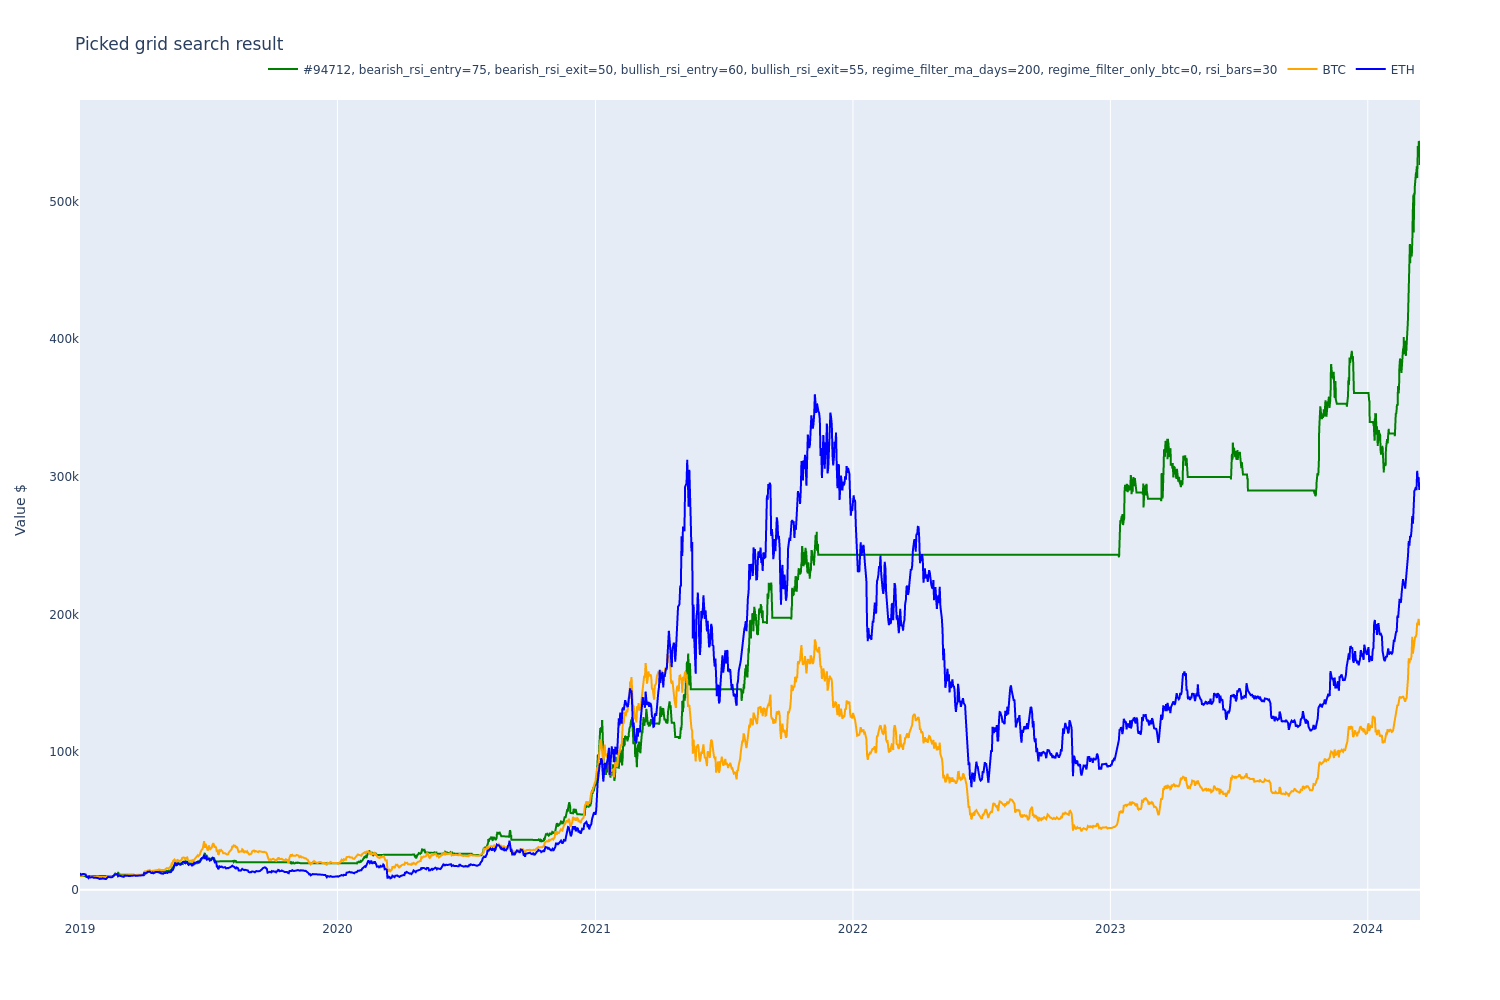

In [16]:
fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

## Best result - BTC regime filter

In [17]:
filtered_results = [r for r in grid_search_results if r.combination.get_parameter("regime_filter_only_btc") == 1]

best_results = find_best_grid_search_results(filtered_results)
print("By CAGR")
render_grid_search_result_table(best_results.cagr)

By CAGR


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_days 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 50 
 55 
 50 
 nan 
 1 
 30 
 111 
 666 
 56.00% 
 100.95% 
 -35.00% 
 1.610000 
 2.420000 
 0.48% 
 -1.54% 
 
 
 60 
 55 
 200.000000 
 1 
 30 
 164 
 643 
 50.00% 
 98.39% 
 -46.00% 
 1.620000 
 2.440000 
 0.07% 
 -1.49% 
 
 
 55 
 50 
 50 
 75 
 150.000000 
 1 
 30 
 58 
 772 
 73.00% 
 104.84% 
 -56.00% 
 1.520000 
 2.200000 
 2.24% 
 -0.06% 
 
 
 80 
 150.000000 
 1 
 30 
 47 
 802 
 77.00% 
 111.25% 
 -57.00% 
 1.530000 
 2.200000 
 0.65% 
 -0.70% 
 
 
 200.000000 
 1 
 30 
 45 
 823 
 79.00% 
 100.31% 
 -57.00% 
 1.430000 
 2.040000 
 0.55% 
 -0.70% 
 
 
 55 
 55 
 200.000000 
 1 
 30 
 220 
 813 
 53.00% 
 97.43% 
 -35.00% 
 1.610000 
 2.450000 
 -0.06% 
 -1.40% 
 
 
 60 
 55 
 150.000000 
 1 
 30 
 108 
 485 
 46.00% 
 107.07% 
 -36.00% 
 1.750000 
 2.670000 
 0.74% 
 -1.47% 
 
 
 80 
 150.000000 
 1 
 30 
 48 
 883 
 78.00% 
 109.17% 
 -60.00% 
 1.510000 
 2.180000 
 0.56% 
 -0.59% 
 
 
 54 
 50 
 55 
 50.000000 
 1 
 21 
 179 
 650 
 65.00% 
 103.64% 
 -55.00% 
 1.590000 
 2.320000 
 1.66% 
 -0.34% 
 
 
 60 
 55 
 100.000000 
 1 
 30 
 127 
 500 
 43.00% 
 106.39% 
 -36.00% 
 1.770000 
 2.700000 
 0.73% 
 -1.66% 
 
 
 60 
 50 
 60 
 55 
 150.000000 
 1 
 30 
 93 
 414 
 42.00% 
 102.62% 
 -36.00% 
 1.740000 
 2.650000 
 0.97% 
 -1.04% 
 
 
 80 
 150.000000 
 1 
 30 
 36 
 806 
 74.00% 
 99.22% 
 -63.00% 
 1.450000 
 2.080000 
 0.93% 
 1.26% 
 
 
 75 
 60 
 50 
 50.000000 
 1 
 30 
 61 
 572 
 63.00% 
 102.17% 
 -59.00% 
 1.490000 
 2.190000 
 1.82% 
 0.71% 
 
 
 65 
 50 
 60 
 75 
 50.000000 
 1 
 21 
 70 
 619 
 63.00% 
 112.89% 
 -47.00% 
 1.690000 
 2.580000 
 3.15% 
 2.83% 
 
 
 65 
 50 
 55 
 50.000000 
 1 
 21 
 117 
 550 
 65.00% 
 108.24% 
 -57.00% 
 1.670000 
 2.440000 
 2.89% 
 0.97% 
 
 
 55 
 50 
 50.000000 
 1 
 30 
 83 
 631 
 63.00% 
 113.86% 
 -48.00% 
 1.670000 
 2.490000 
 1.56% 
 -0.12% 
 
 
 67 
 55 
 50 
 50.000000 
 1 
 30 
 81 
 651 
 63.00% 
 115.36% 
 -50.00% 
 1.680000 
 2.490000 
 1.70% 
 -0.10% 
 
 
 70 
 55 
 50 
 50.000000 
 1 
 30 
 78 
 641 
 63.00% 
 125.52% 
 -47.00% 
 1.750000 
 2.610000 
 2.00% 
 -0.11% 
 
 
 60 
 50 
 50.000000 
 1 
 30 
 62 
 554 
 57.00% 
 117.34% 
 -54.00% 
 1.730000 
 2.580000 
 3.04% 
 0.98% 
 
 
 70 
 65 
 55 
 50 
 50.000000 
 1 
 30 
 78 
 622 
 62.00% 
 109.69% 
 -48.00% 
 1.660000 
 2.450000 
 1.52% 
 -0.17%

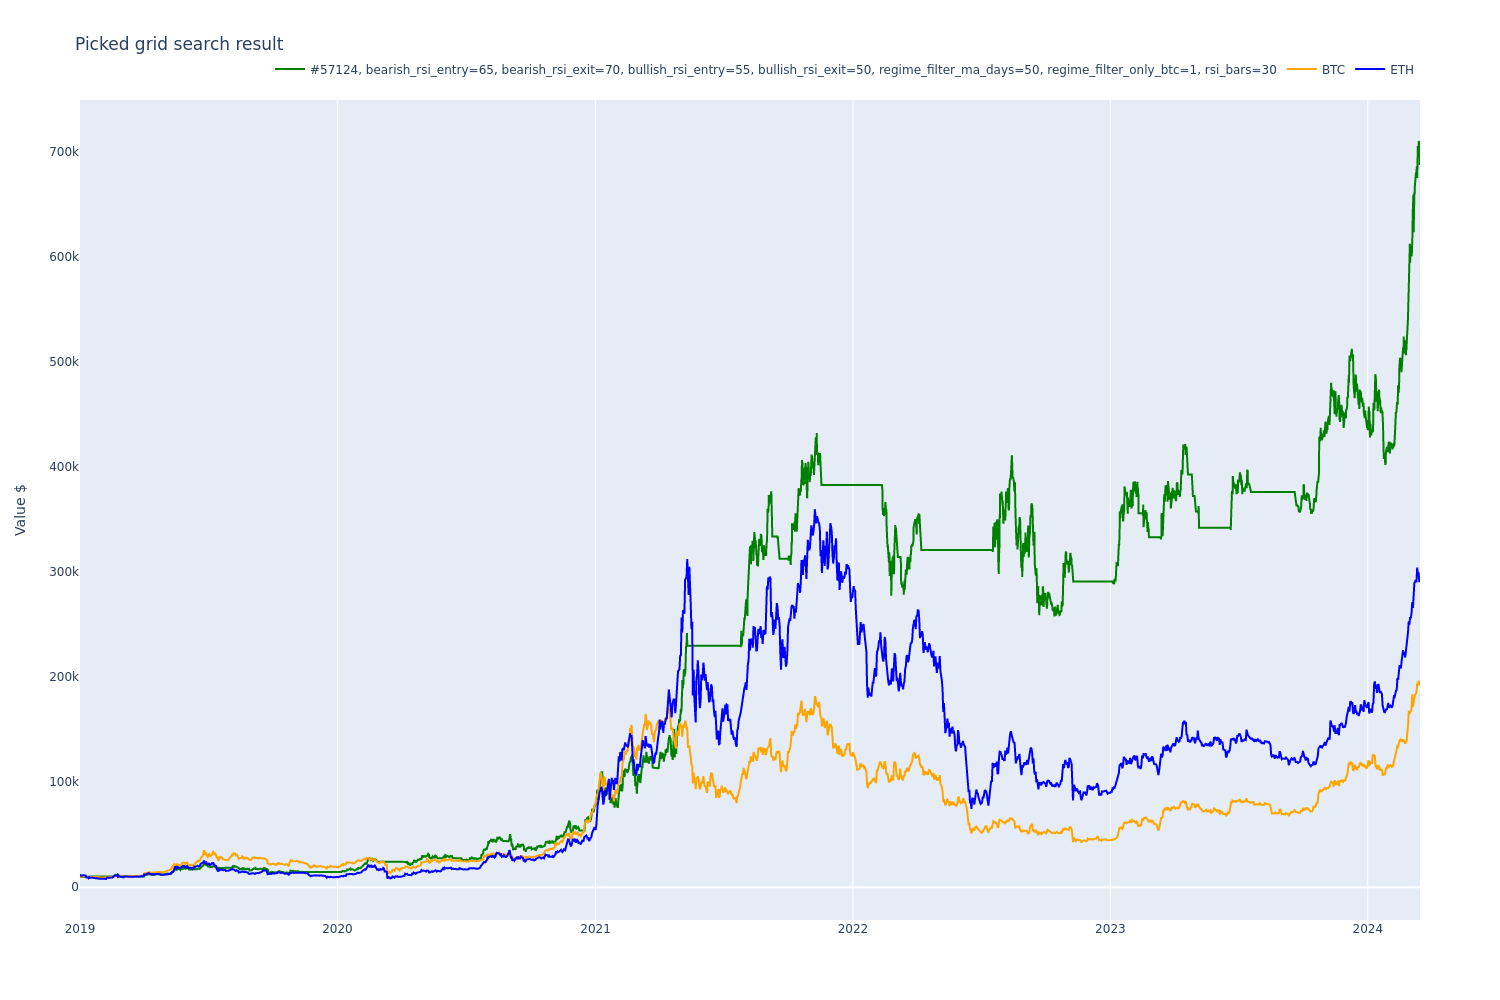

In [18]:
fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

In [19]:
print("By Sharpe")
render_grid_search_result_table(best_results.sharpe)


By Sharpe


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_days 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50.000000 
 50 
 60 
 55 
 nan 
 1 
 30 
 99 
 414 
 40.00% 
 95.13% 
 -36.00% 
 1.690000 
 2.560000 
 0.95% 
 -1.54% 
 
 
 55.000000 
 50 
 60 
 55 
 100.000000 
 1 
 30 
 110 
 476 
 46.00% 
 101.14% 
 -36.00% 
 1.680000 
 2.560000 
 0.75% 
 -1.47% 
 
 
 150.000000 
 1 
 30 
 108 
 485 
 46.00% 
 107.07% 
 -36.00% 
 1.750000 
 2.670000 
 0.74% 
 -1.47% 
 
 
 200.000000 
 1 
 30 
 106 
 480 
 46.00% 
 111.07% 
 -36.00% 
 1.790000 
 2.730000 
 0.75% 
 -1.27% 
 
 
 54 
 55 
 50 
 50.000000 
 1 
 30 
 119 
 689 
 55.00% 
 111.33% 
 -34.00% 
 1.710000 
 2.570000 
 0.75% 
 -1.57% 
 
 
 60 
 55 
 100.000000 
 1 
 30 
 127 
 500 
 43.00% 
 106.39% 
 -36.00% 
 1.770000 
 2.700000 
 0.73% 
 -1.66% 
 
 
 150.000000 
 1 
 30 
 127 
 510 
 43.00% 
 104.14% 
 -36.00% 
 1.740000 
 2.660000 
 0.62% 
 -1.63% 
 
 
 60.000000 
 50 
 60 
 55 
 100.000000 
 1 
 30 
 95 
 411 
 42.00% 
 93.67% 
 -36.00% 
 1.650000 
 2.490000 
 0.81% 
 -1.14% 
 
 
 54 
 60 
 55 
 200.000000 
 1 
 30 
 97 
 415 
 41.00% 
 99.81% 
 -36.00% 
 1.730000 
 2.640000 
 1.02% 
 -1.14% 
 
 
 60 
 60 
 55 
 200.000000 
 1 
 30 
 117 
 453 
 40.00% 
 94.75% 
 -36.00% 
 1.700000 
 2.570000 
 0.87% 
 -1.04% 
 
 
 65.000000 
 50 
 60 
 55 
 150.000000 
 1 
 30 
 84 
 356 
 38.00% 
 91.36% 
 -36.00% 
 1.670000 
 2.540000 
 1.08% 
 -1.09% 
 
 
 54 
 60 
 55 
 50.000000 
 1 
 30 
 97 
 412 
 40.00% 
 91.45% 
 -39.00% 
 1.660000 
 2.510000 
 0.90% 
 -1.63% 
 
 
 70 
 60 
 55 
 50.000000 
 1 
 30 
 92 
 420 
 48.00% 
 109.17% 
 -43.00% 
 1.760000 
 2.670000 
 1.40% 
 -1.00% 
 
 
 67.000000 
 60 
 70 
 50 
 50.000000 
 1 
 12 
 120 
 452 
 41.00% 
 92.32% 
 -33.00% 
 1.720000 
 2.640000 
 1.30% 
 -1.35% 
 
 
 70.000000 
 54 
 60 
 55 
 100.000000 
 1 
 30 
 79 
 340 
 34.00% 
 98.26% 
 -36.00% 
 1.820000 
 2.770000 
 1.38% 
 -0.55% 
 
 
 67 
 60 
 55 
 100.000000 
 1 
 30 
 80 
 347 
 38.00% 
 98.51% 
 -36.00% 
 1.810000 
 2.760000 
 1.34% 
 -0.67% 
 
 
 75.000000 
 60 
 70 
 50 
 50.000000 
 1 
 12 
 98 
 396 
 37.00% 
 91.31% 
 -30.00% 
 1.780000 
 2.730000 
 1.56% 
 -1.09% 
 
 
 65 
 60 
 55 
 100.000000 
 1 
 30 
 79 
 345 
 38.00% 
 101.21% 
 -36.00% 
 1.840000 
 2.800000 
 1.42% 
 -0.55% 
 
 
 67 
 60 
 55 
 100.000000 
 1 
 30 
 79 
 345 
 38.00% 
 100.04% 
 -36.00% 
 1.830000 
 2.790000 
 1.41% 
 -0.55% 
 
 
 nan 
 60 
 70 
 50 
 50.000000 
 1 
 12 
 92 
 382 
 36.00% 
 91.04% 
 -30.00% 
 1.800000 
 2.760000 
 1.65% 
 -1.04%

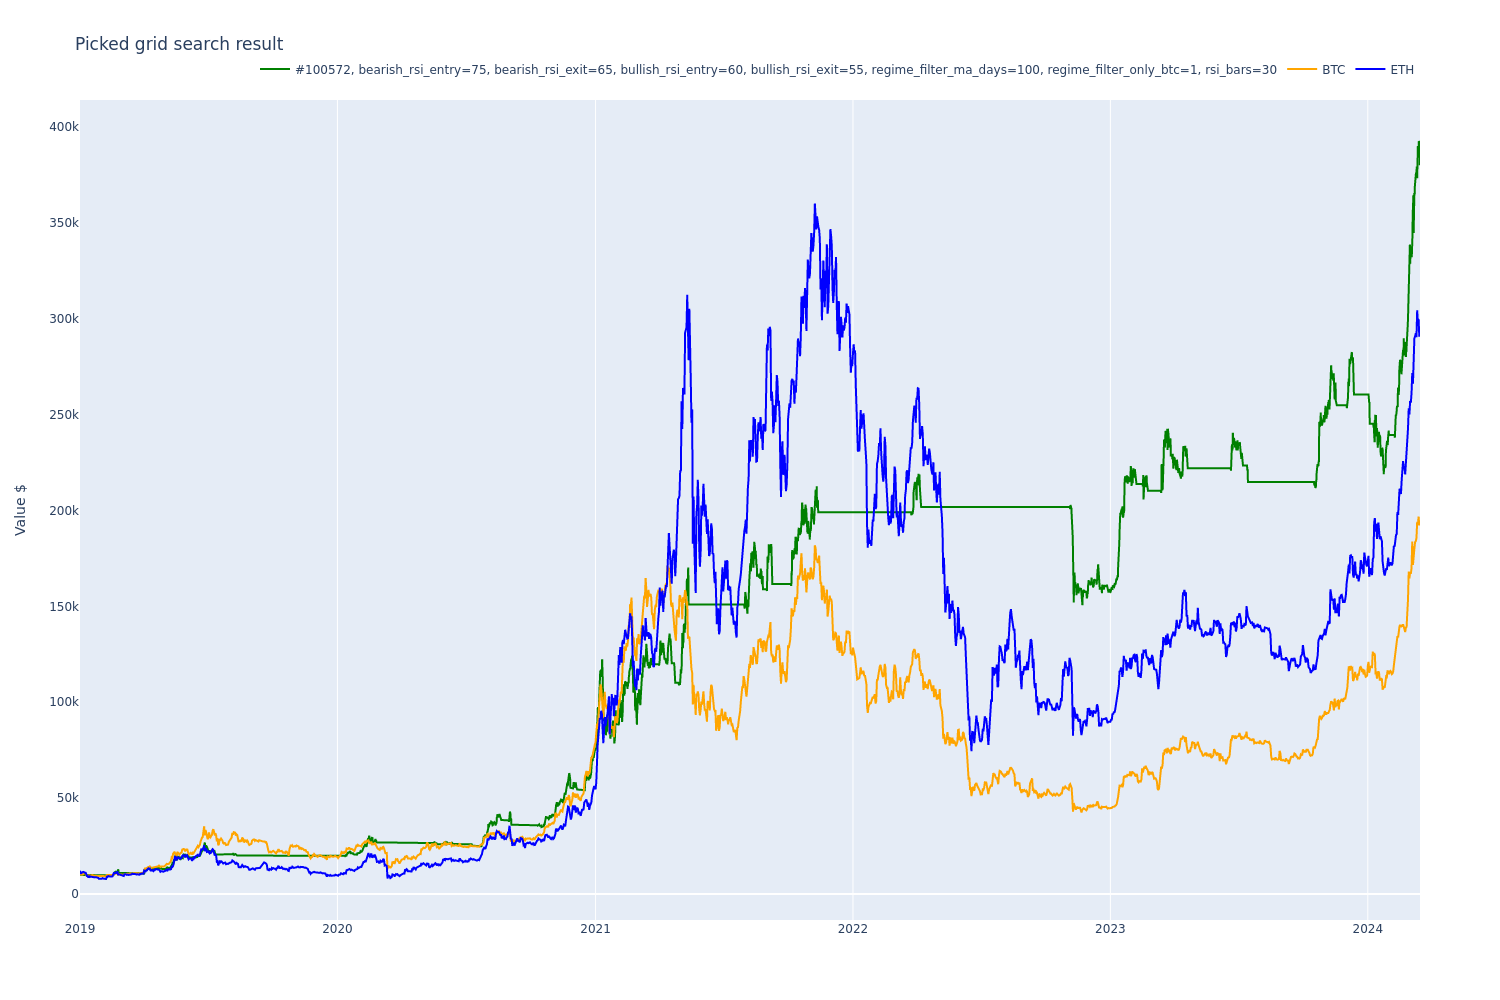

In [20]:
fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

## Best result - pair regime filter

In [21]:
filtered_results = [r for r in grid_search_results if r.combination.get_parameter("regime_filter_only_btc") == 0]

best_results = find_best_grid_search_results(filtered_results)
print("By CAGR")
render_grid_search_result_table(best_results.cagr)

By CAGR


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_days 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 50 
 55 
 50 
 100.000000 
 0 
 30 
 162 
 817 
 60.00% 
 99.13% 
 -42.00% 
 1.570000 
 2.370000 
 0.06% 
 -1.41% 
 
 
 nan 
 0 
 30 
 111 
 666 
 56.00% 
 100.95% 
 -35.00% 
 1.610000 
 2.420000 
 0.48% 
 -1.54% 
 
 
 60 
 55 
 100.000000 
 0 
 30 
 161 
 628 
 50.00% 
 106.72% 
 -40.00% 
 1.720000 
 2.630000 
 0.37% 
 -1.25% 
 
 
 200.000000 
 0 
 30 
 163 
 646 
 50.00% 
 103.75% 
 -41.00% 
 1.680000 
 2.560000 
 0.22% 
 -1.41% 
 
 
 55 
 50 
 50 
 80 
 200.000000 
 0 
 30 
 44 
 829 
 81.00% 
 97.34% 
 -57.00% 
 1.390000 
 1.990000 
 0.80% 
 -0.70% 
 
 
 60 
 55 
 100.000000 
 0 
 30 
 109 
 475 
 45.00% 
 109.65% 
 -36.00% 
 1.780000 
 2.720000 
 0.98% 
 -1.14% 
 
 
 150.000000 
 0 
 30 
 108 
 485 
 46.00% 
 106.41% 
 -36.00% 
 1.750000 
 2.660000 
 0.80% 
 -1.27% 
 
 
 200.000000 
 0 
 30 
 105 
 486 
 46.00% 
 114.92% 
 -36.00% 
 1.820000 
 2.790000 
 0.88% 
 -1.14% 
 
 
 54 
 60 
 50 
 50.000000 
 0 
 30 
 88 
 529 
 52.00% 
 95.95% 
 -47.00% 
 1.580000 
 2.340000 
 0.81% 
 -1.39% 
 
 
 55 
 50.000000 
 0 
 30 
 114 
 446 
 42.00% 
 97.54% 
 -36.00% 
 1.700000 
 2.590000 
 0.77% 
 -1.62% 
 
 
 100.000000 
 0 
 30 
 124 
 495 
 43.00% 
 112.60% 
 -36.00% 
 1.830000 
 2.810000 
 0.88% 
 -1.54% 
 
 
 65 
 60 
 55 
 100.000000 
 0 
 30 
 93 
 503 
 58.00% 
 102.15% 
 -49.00% 
 1.610000 
 2.410000 
 1.90% 
 0.28% 
 
 
 60 
 50 
 60 
 55 
 200.000000 
 0 
 30 
 92 
 419 
 42.00% 
 105.34% 
 -36.00% 
 1.770000 
 2.690000 
 0.98% 
 -1.09% 
 
 
 54 
 55 
 80 
 200.000000 
 0 
 30 
 33 
 809 
 79.00% 
 99.79% 
 -58.00% 
 1.420000 
 2.030000 
 2.18% 
 1.43% 
 
 
 67 
 60 
 50 
 50.000000 
 0 
 30 
 64 
 564 
 57.00% 
 110.92% 
 -52.00% 
 1.690000 
 2.520000 
 2.13% 
 1.18% 
 
 
 65 
 50 
 55 
 50 
 50.000000 
 0 
 30 
 93 
 586 
 53.00% 
 109.26% 
 -35.00% 
 1.730000 
 2.590000 
 1.04% 
 -0.79% 
 
 
 65 
 60 
 55 
 200.000000 
 0 
 30 
 95 
 413 
 37.00% 
 102.79% 
 -36.00% 
 1.830000 
 2.790000 
 1.02% 
 -0.27% 
 
 
 67 
 60 
 75 
 200.000000 
 0 
 30 
 40 
 806 
 81.00% 
 107.96% 
 -64.00% 
 1.490000 
 2.160000 
 3.89% 
 2.47% 
 
 
 80 
 200.000000 
 0 
 30 
 26 
 1004 
 84.00% 
 111.89% 
 -68.00% 
 1.490000 
 2.140000 
 3.47% 
 1.32% 
 
 
 75 
 50 
 60 
 55 
 200.000000 
 0 
 30 
 75 
 332 
 35.00% 
 114.23% 
 -36.00% 
 1.970000 
 3.020000 
 1.74% 
 -0.55%

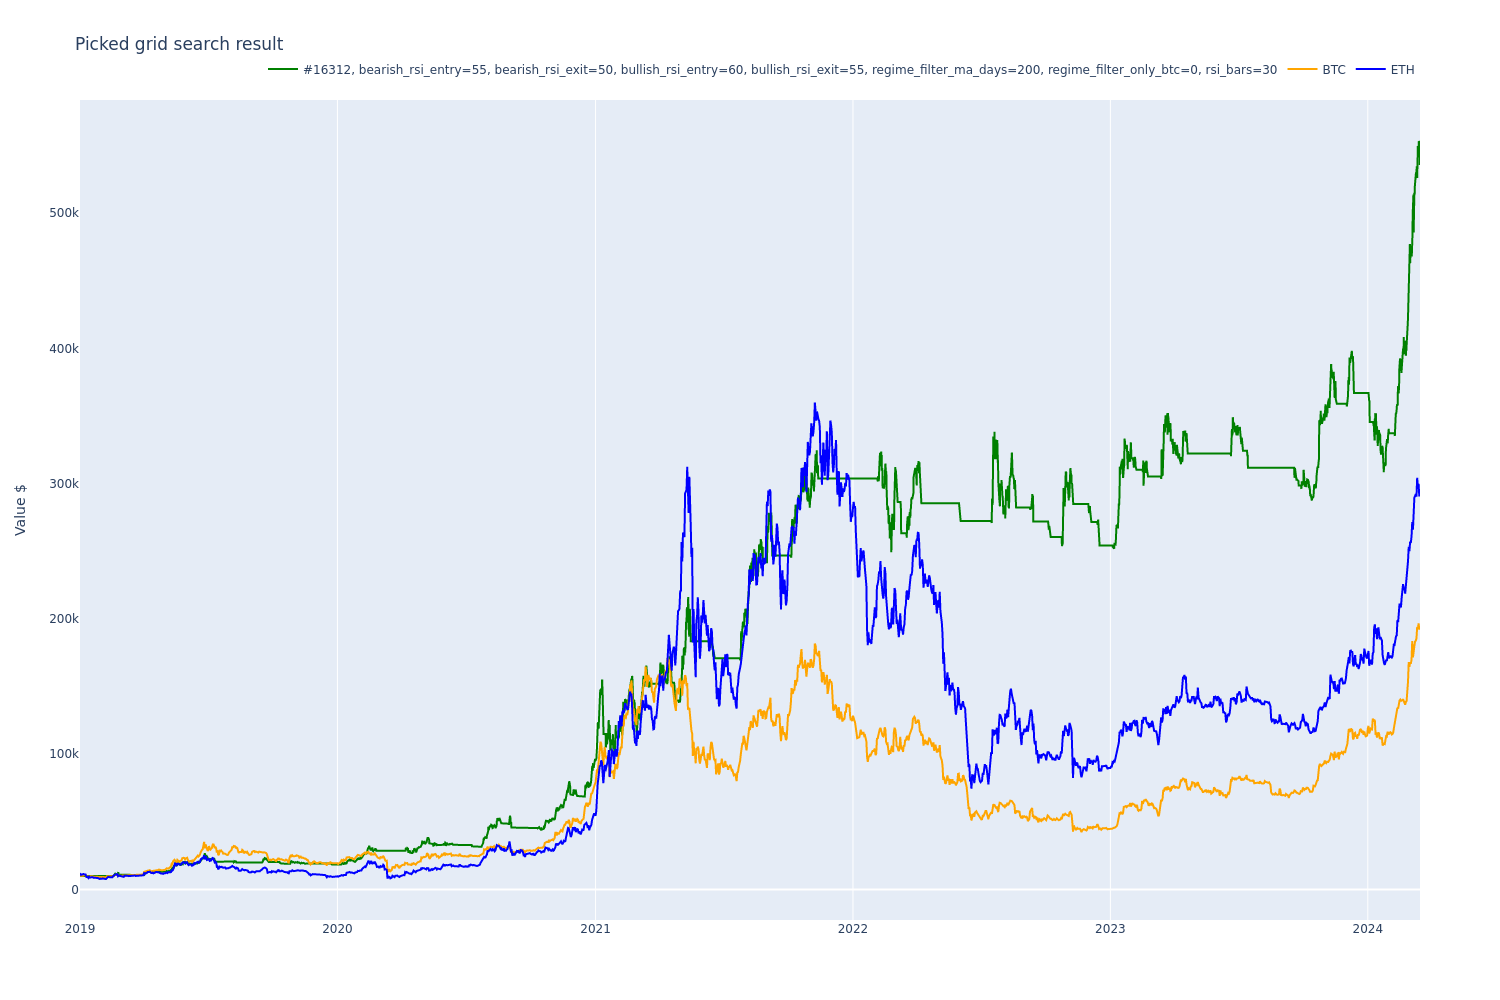

In [22]:

fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

In [23]:
print("By Sharpe")
render_grid_search_result_table(best_results.sharpe)

By Sharpe


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_days 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 50 
 60 
 55 
 100 
 0 
 30 
 161 
 628 
 50.00% 
 106.72% 
 -40.00% 
 1.720000 
 2.630000 
 0.37% 
 -1.25% 
 
 
 55 
 50 
 60 
 55 
 100 
 0 
 30 
 109 
 475 
 45.00% 
 109.65% 
 -36.00% 
 1.780000 
 2.720000 
 0.98% 
 -1.14% 
 
 
 150 
 0 
 30 
 108 
 485 
 46.00% 
 106.41% 
 -36.00% 
 1.750000 
 2.660000 
 0.80% 
 -1.27% 
 
 
 200 
 0 
 30 
 105 
 486 
 46.00% 
 114.92% 
 -36.00% 
 1.820000 
 2.790000 
 0.88% 
 -1.14% 
 
 
 54 
 60 
 55 
 100 
 0 
 30 
 124 
 495 
 43.00% 
 112.60% 
 -36.00% 
 1.830000 
 2.810000 
 0.88% 
 -1.54% 
 
 
 200 
 0 
 30 
 125 
 507 
 43.00% 
 105.76% 
 -36.00% 
 1.760000 
 2.690000 
 0.66% 
 -1.63% 
 
 
 60 
 50 
 60 
 55 
 200 
 0 
 30 
 92 
 419 
 42.00% 
 105.34% 
 -36.00% 
 1.770000 
 2.690000 
 0.98% 
 -1.09% 
 
 
 54 
 60 
 55 
 150 
 0 
 30 
 97 
 412 
 41.00% 
 100.25% 
 -36.00% 
 1.740000 
 2.650000 
 1.05% 
 -1.14% 
 
 
 200 
 0 
 30 
 97 
 415 
 41.00% 
 99.81% 
 -36.00% 
 1.730000 
 2.640000 
 1.02% 
 -1.14% 
 
 
 65 
 50 
 60 
 55 
 200 
 0 
 30 
 81 
 363 
 39.00% 
 103.96% 
 -36.00% 
 1.810000 
 2.750000 
 1.33% 
 -0.79% 
 
 
 67 
 50 
 55 
 50 
 50 
 0 
 30 
 92 
 584 
 52.00% 
 114.72% 
 -35.00% 
 1.790000 
 2.680000 
 1.19% 
 -0.69% 
 
 
 70 
 50 
 60 
 55 
 150 
 0 
 30 
 81 
 347 
 36.00% 
 99.97% 
 -36.00% 
 1.800000 
 2.730000 
 1.09% 
 -1.14% 
 
 
 200 
 0 
 30 
 76 
 347 
 36.00% 
 112.38% 
 -36.00% 
 1.930000 
 2.950000 
 1.61% 
 -0.33% 
 
 
 60 
 60 
 55 
 200 
 0 
 30 
 77 
 349 
 35.00% 
 112.54% 
 -36.00% 
 1.940000 
 2.970000 
 1.66% 
 -0.55% 
 
 
 65 
 60 
 55 
 200 
 0 
 30 
 78 
 351 
 35.00% 
 109.12% 
 -36.00% 
 1.910000 
 2.930000 
 1.53% 
 -0.67% 
 
 
 70 
 60 
 55 
 200 
 0 
 30 
 79 
 341 
 35.00% 
 113.04% 
 -36.00% 
 1.950000 
 3.000000 
 1.58% 
 -0.84% 
 
 
 75 
 50 
 60 
 55 
 200 
 0 
 30 
 75 
 332 
 35.00% 
 114.23% 
 -36.00% 
 1.970000 
 3.020000 
 1.74% 
 -0.55% 
 
 
 54 
 60 
 55 
 200 
 0 
 30 
 77 
 336 
 34.00% 
 106.15% 
 -36.00% 
 1.890000 
 2.890000 
 1.45% 
 -1.04% 
 
 
 80 
 50 
 60 
 55 
 200 
 0 
 30 
 75 
 332 
 35.00% 
 113.35% 
 -36.00% 
 1.960000 
 3.010000 
 1.73% 
 -0.55% 
 
 
 54 
 60 
 55 
 200 
 0 
 30 
 77 
 336 
 34.00% 
 105.31% 
 -36.00% 
 1.880000 
 2.870000 
 1.44% 
 -1.04%

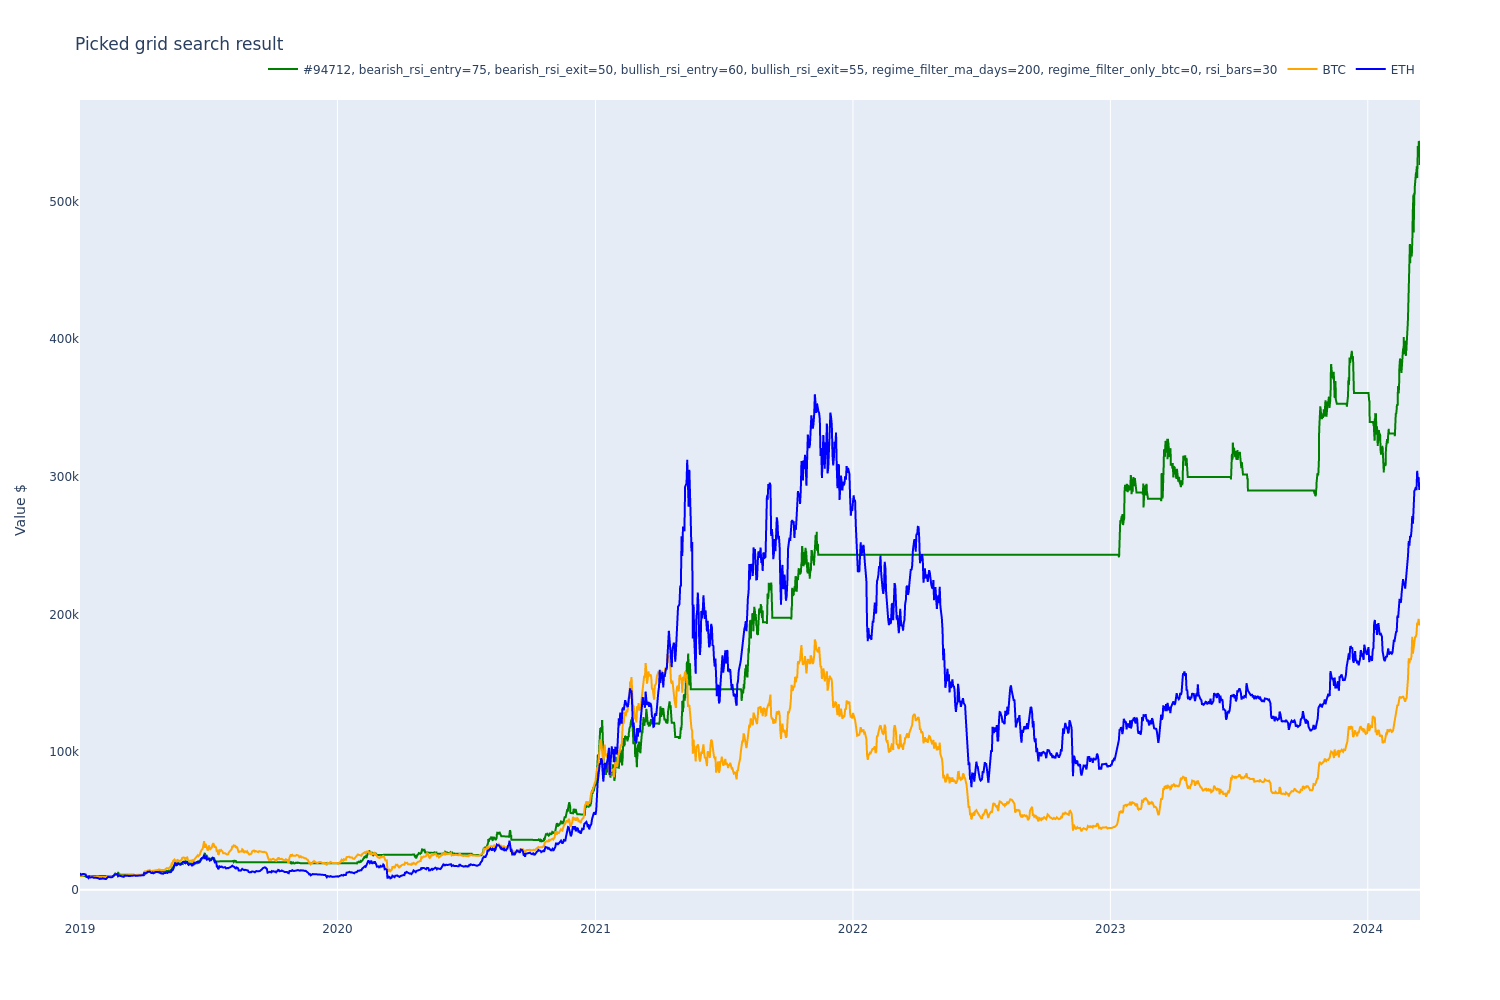

In [24]:

fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()